In [2]:
# 导入相关的库
import matplotlib.pyplot as plt
import numpy as np

import copy
import os
import random
from collections import deque

import torch

import gym
import gym_super_mario_bros
from gym.spaces import Box
from gym.wrappers import FrameStack


from nes_py.wrappers import JoypadSpace
from torch import nn
from torchvision import transforms

# 使用GPU
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# 初始化马里奥环境: https://pypi.org/project/gym-super-mario-bros/

# SuperMarioBros-<world>-<stage>-v<version>

# <world> is a number in {1, 2, 3, 4, 5, 6, 7, 8} indicating the world
# <stage> is a number in {1, 2, 3, 4} indicating the stage within a world
# <version> is a number in {0, 1, 2, 3} specifying the ROM mode to use
    # 0: standard ROM
    # 1: downsampled ROM
    # 2: pixel ROM
    # 3: rectangle ROM

env = gym_super_mario_bros.make("SuperMarioBros-1-1-v0")

# 限制 Action-space（所有可能出现的动作）：向左、向左跳、向右、向右跳
env = JoypadSpace(env, [["left"],["left", "A"],["right"], ["right", "A"]])



In [4]:
# 初始化环境，重置环境，并返回当前State
obs = env.reset() 

In [5]:
obs.shape

(240, 256, 3)

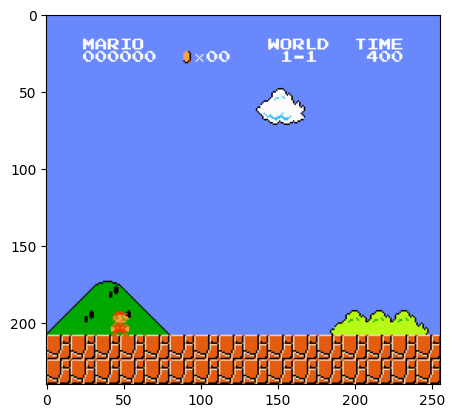

In [6]:
# 绘制
plt.imshow(obs)

In [7]:
# Agent做出一个动作，环境返回下一时刻的状态、奖励、是否结束、其他信息
# step的参数Action：action-sapce中的动作索引
obs, reward, done, info = env.step(action=3)

In [8]:
obs.shape, reward, done, info

((240, 256, 3),
 0.0,
 False,
 {'coins': 0,
  'flag_get': False,
  'life': 2,
  'score': 0,
  'stage': 1,
  'status': 'small',
  'time': 400,
  'world': 1,
  'x_pos': 40,
  'y_pos': 79})

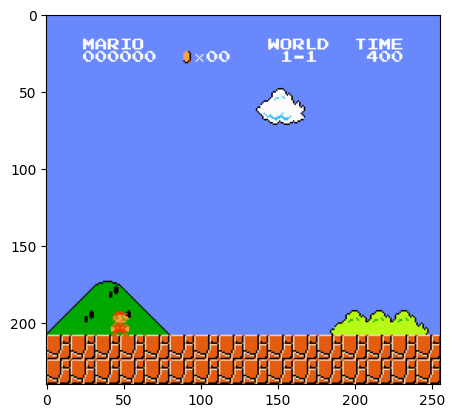

In [9]:
plt.imshow(obs)


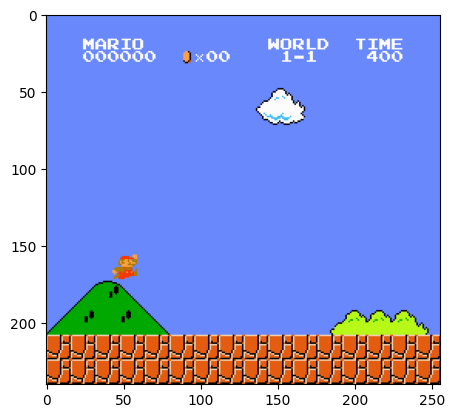

In [10]:
# 多运行几次，可以看到Mario向右上角运动
for i in range(10):
    obs, reward, done, info = env.step(action=3)
plt.imshow(obs)

In [11]:
# 预处理环境
# 原始游戏的图像的大小为：(240, 256, 3)，在传给网络前需要过滤掉一些不用的信息（如画面的颜色信息）
# 使用gym.Wrapper模块进行预处理，可以自定义类（需要继承gym.Wrapper）

In [13]:
# 因为连续多个帧画面之间区别不大，可以间隔一些帧采样提高效率，主要重写了 step 函数
# 但是Reward需要累加再返回
class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

# 将画面转为灰度图
# 通道顺序调整[H, W, C]  to [C, H, W]，处理后大小：[1, 240, 256]
class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.observation_space = Box(low=0, high=255, shape=self.observation_space.shape[:2], dtype=np.uint8)

    def observation(self, observation):
        transform = transforms.Grayscale()
        return transform(torch.tensor(np.transpose(observation, (2, 0, 1)).copy(), dtype=torch.float))

# 缩放，处理后大小 [1, 84, 84]
class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        self.shape = (shape, shape)
        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        transformations = transforms.Compose([transforms.Resize(self.shape), transforms.Normalize(0, 255)])
        return transformations(observation).squeeze(0)

In [14]:
# 对画面进行调整，处理完大小：(1, 84, 84)
env = SkipFrame(env, skip=4)
env = GrayScaleObservation(env)
env = ResizeObservation(env, shape=84)

# 打包最新的4帧画面，大小：(4, 84, 84)，打包4帧的原因是为了让Agent能够感知到Mario的运动方向，因为单帧画面无法感知到运动方向。需要运动方向的信息才能更好的学习到游戏规则
env = FrameStack(env, num_stack=4)
    

# 随机种子
env.seed(42)
env.action_space.seed(42)
torch.manual_seed(42)
torch.random.manual_seed(42)
random.seed(42)
np.random.seed(42)


In [15]:
# 重置
obs = env.reset()

c:\Users\yyx89\.conda\envs\ai02_rlGame\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [16]:
# 可以看到状态变了
obs.shape

(4, 84, 84)

(4, 84, 84)


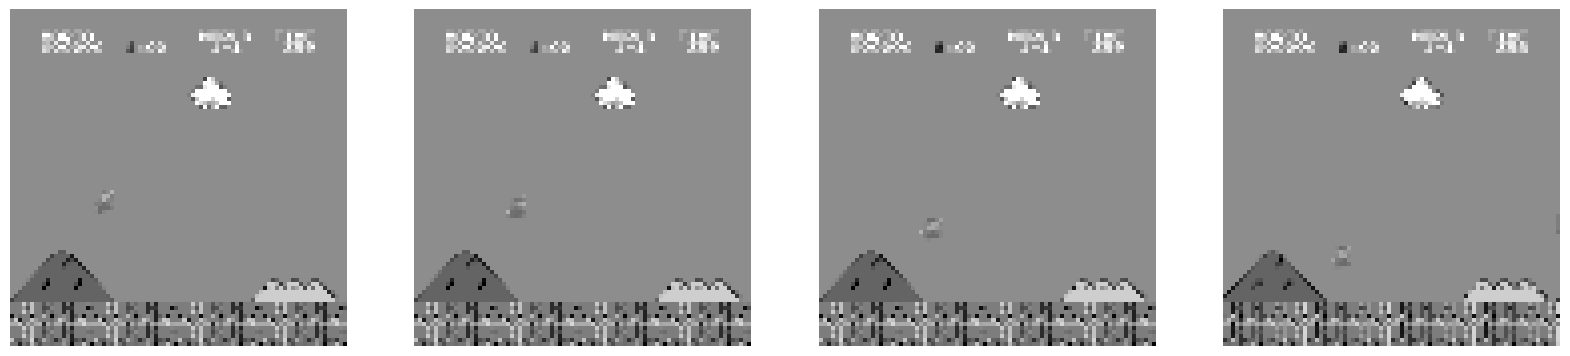

In [17]:
# 多运行几次，可以看到Mario向右上角运动
for i in range(10):
    obs, reward, done, info = env.step(action=3)
print(obs.shape)

# 绘制这4帧
plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(obs[i], cmap="gray")
    plt.axis("off")

In [18]:
# 这样预处理完毕，每次Agent做完一个Action，Environment会返回(4, 84, 84)这样的一个State（4张相邻画面的灰度图）

In [19]:
# Double deep Q-Network 定义
class DDQNSolver(nn.Module):
    # CNN架构：input -> (conv2d + relu) x 3 -> flatten -> (dense + relu) x 2 -> output
    
    def __init__(self, output_dim):
        super().__init__()
        # 定义Online network
        self.online = nn.Sequential(
            nn.Conv2d(in_channels=4, out_channels=32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, 512),
            nn.ReLU(),
            nn.Linear(512, output_dim),
        )
        # 定义Target network（直接复制Online network）
        self.target = copy.deepcopy(self.online)
        # 将target network参数冻结
        for p in self.target.parameters():
            p.requires_grad = False

    def forward(self, input, model):
        if model == "online":
            return self.online(input)
        elif model == "target":
            return self.target(input)


# Agent执行的类，主要有4个功能
# act函数：基于当前状态返回对应的动作ID
# remember函数：Agent需要缓存之前的一些信息来更新动作策略（state, next_state, action, reward, done）
# recall函数：回忆之前缓存的信息
# experience_replay：经验回放、学习
class DDQNAgent:
    def __init__(self, action_dim, save_directory):
        self.action_dim = action_dim
        self.save_directory = save_directory
        if not os.path.exists(self.save_directory):
            os.makedirs(self.save_directory)
        self.net = DDQNSolver(self.action_dim).to(device)
        self.exploration_rate = 1.0 # 控制探索和利用的概率
        self.exploration_rate_decay = 0.99
        self.exploration_rate_min = 0.01
        self.current_step = 0
        self.memory = deque(maxlen=100000)
        self.batch_size = 32
        self.gamma = 0.95
        self.sync_period = 1e4
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.00025, eps=1e-4)
        self.loss = torch.nn.SmoothL1Loss()
        self.episode_rewards = []
        self.moving_average_episode_rewards = []
        self.current_episode_reward = 0.0

    def log_episode(self):
        self.episode_rewards.append(self.current_episode_reward)
        self.current_episode_reward = 0.0

    def log_period(self, episode, epsilon, step):
        self.moving_average_episode_rewards.append(np.round(np.mean(self.episode_rewards[-checkpoint_period:]), 3))
        print(f"Episode {episode} - Step {step} - Epsilon {epsilon} - Mean Reward {self.moving_average_episode_rewards[-1]}")
        plt.plot(self.moving_average_episode_rewards)
        plt.savefig(os.path.join(self.save_directory, f"episode_rewards_plot_{episode}.png"))
        plt.clf()

    # remember函数：Agent需要缓存之前的一些信息来更新动作策略（state, next_state, action, reward, done）
    def remember(self, state, next_state, action, reward, done):
        self.memory.append((torch.tensor(state.__array__()), torch.tensor(next_state.__array__()),
                            torch.tensor([action]), torch.tensor([reward]), torch.tensor([done])))
    
    # 经验回放、学习
    def experience_replay(self, step_reward):
        self.current_episode_reward += step_reward  # 更新当前回合的奖励

        # 在一定的步数间隔内，将Target网络与Online网络同步参数
        if self.current_step % self.sync_period == 0:
            self.net.target.load_state_dict(self.net.online.state_dict())

        # 如果批处理大小大于记忆体中的样本数量，返回（样本不足）
        if self.batch_size > len(self.memory):
            return

        # 获取记忆中数据
        state, next_state, action, reward, done = self.recall()

        # 从Online网络获取预测 Q 值
        q_estimate = self.net(state.to(device), model="online")[np.arange(0, self.batch_size), action.to(device)]

        # 使用目标网络计算目标 Q 值，无需更新参数
        with torch.no_grad():
            # 最优动作
            best_action = torch.argmax(self.net(next_state.to(device), model="online"), dim=1)
            # 新状态下最大Q
            next_q = self.net(next_state.to(device), model="target")[np.arange(0, self.batch_size), best_action]
            # 目标Q值（使用done区分游戏是否结束，0、1分别表示未结束、已结束）
            q_target = (reward.to(device) + (1 - done.to(device).float()) * self.gamma * next_q  ).float()

        # 计算损失
        loss = self.loss(q_estimate, q_target)
        # 执行反向传播并更新在线网络
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()



    # recall函数：回忆之前缓存的信息（随机采样）
    def recall(self):
        state, next_state, action, reward, done = map(torch.stack, zip(*random.sample(self.memory, self.batch_size)))
        return state, next_state, action.squeeze(), reward.squeeze(), done.squeeze()

    # act函数：基于当前状态和最优动作策略（optimaloptimal action policy）返回对应的动作ID
    def act(self, state):
        # 随机动作（探索和利用概率）
        if np.random.rand() < self.exploration_rate:
            action = np.random.randint(self.action_dim)
        # 根据策略执行动作
        else:
            # 将图像数据输入网络 4,84，84 -> 1,4,84,84
            action_values = self.net(torch.tensor(state.__array__()).to(device).unsqueeze(0), model="online")
            # 获取动作ID
            action = torch.argmax(action_values, dim=1).item()

        # 降低 exploration_rate
        self.exploration_rate *= self.exploration_rate_decay
        self.exploration_rate = max(self.exploration_rate_min, self.exploration_rate)
        # 增加步数
        self.current_step += 1
        return action

    # 加载权重
    def load_checkpoint(self, path):
        checkpoint = torch.load(path, map_location='cpu')
        self.net.load_state_dict(checkpoint['model'])
        self.exploration_rate = checkpoint['exploration_rate']

    # 保存权重
    def save_checkpoint(self):
        filename = os.path.join(self.save_directory, 'checkpoint_{}.pth'.format(episode))
        torch.save(dict(model=self.net.state_dict(), exploration_rate=self.exploration_rate), f=filename)
        print('Checkpoint saved to \'{}\''.format(filename))


In [20]:
# 权重保存间隔
checkpoint_period = 10
# 保存路径
save_directory = "weights/ddqn/"
# 预训练权重加载（老师训练的）
load_checkpoint = "checkpoint_4action_12060.pth"
# 定义网络
agent = DDQNAgent(action_dim=env.action_space.n, save_directory=save_directory)
# 加载
if load_checkpoint is not None:
    agent.load_checkpoint(save_directory + "/" + load_checkpoint)

In [ ]:
# 训练步骤：
# 1.初始化Q值
# 2.基于当前状态，执行动作
# 3.环境更新到下一状态，获得奖励
# 4.更新网络参数
    # 4.1 记忆之前的信息
    # 4.2 经验回放、学习
# 5.重复2-4步骤


# 启动训练
episode = 0
while True:
    # 初始化
    state = env.reset()
    while True:
        # DDQN 推理得到动作
        action = agent.act(state)
        # GYM渲染显示（AutoDL等云主机训练时，注释这段代码）
        env.render()
        # GYM返回新状态信息
        next_state, reward, done, info = env.step(action)
        # DDQN记忆参数
        agent.remember(state, next_state, action, reward, done)
        # DDQN学习
        agent.experience_replay(reward)
        
        state = next_state
        # 判断是否结束（闯关、死亡都算结束）
        if done:
            episode += 1
            agent.log_episode()
            if episode % checkpoint_period == 0:
                # 记录曲线
                agent.log_period(episode=episode, epsilon=agent.exploration_rate, step=agent.current_step)
                # 保存权重
                agent.save_checkpoint()
            break